Case 1 : \
DATA SET - LS_Group13 \
Covariance Type 1 $$\sigma ^2 I$$

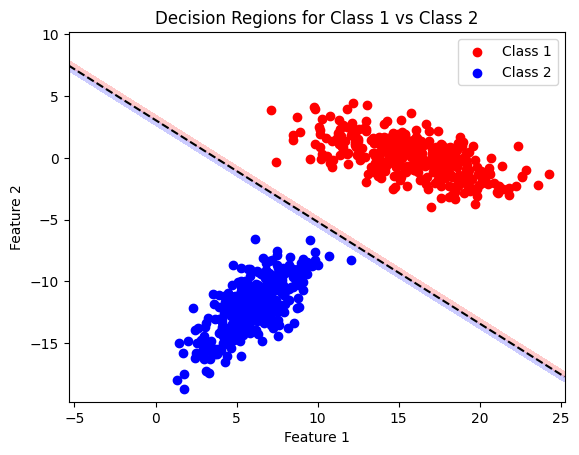

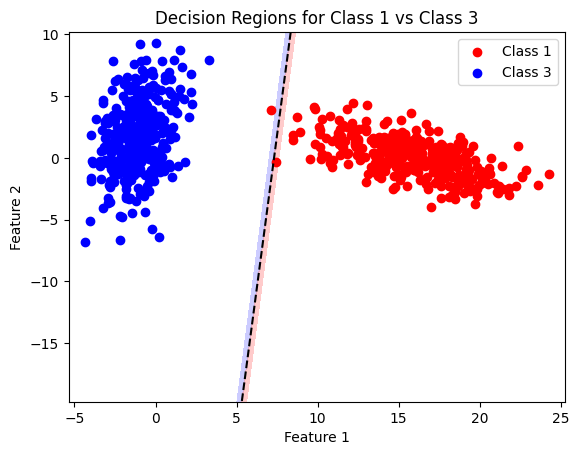

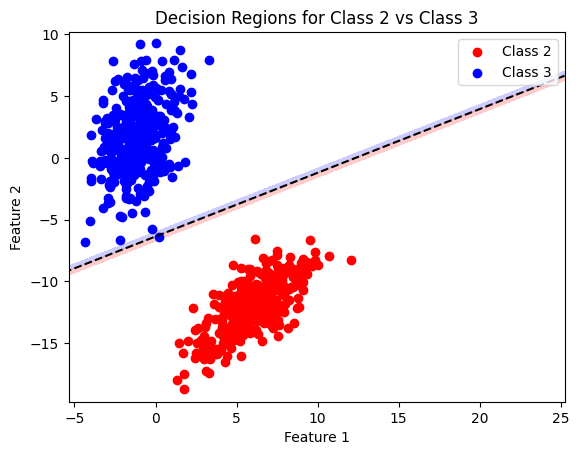

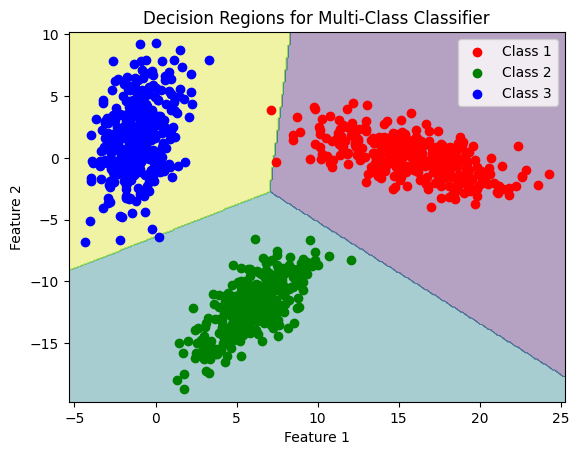

| ClassName        |   Actual_Class1 |   Actual_Class2 |   Actual_Class3 |
|------------------+-----------------+-----------------+-----------------|
| Predicted_class1 |             148 |               0 |               0 |
| Predicted_class2 |               0 |             149 |               0 |
| Predicted_class3 |               1 |               0 |             149 |
Class Accuracies:
 [0.99328859 1.         1.        ]
Class Precisions:
 [1.         1.         0.99333333]
Class Recalls:
 [0.99328859 1.         1.        ]
Class F-Measures:
 [0.996633   1.         0.99665552]
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Precision | 0.997778 |
+-----------+----------+
| Recall    | 0.997763 |
+-----------+----------+
| F1 Score  | 0.997763 |
+-----------+----------+


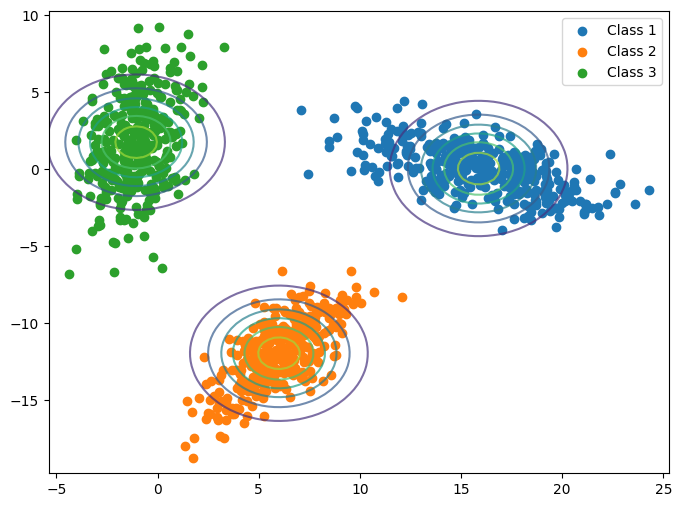

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Step 1: Load the Data
def load_data(file_paths):
    # Load data from all CSV files
    data_classes = [pd.read_csv(file_path).values for file_path in file_paths]
    return data_classes

# Step 2: Compute Covariance Matrices
def compute_covariances(data, option):
    mus = [np.mean(d, axis=0) for d in data]
    
    if option == 1:
        # Option 1: Z = σ² * I (Identity matrix with averaged variance)
        variances = [np.var(d, axis=0) for d in data]
        avg_variance = np.mean([np.mean(var) for var in variances])
        Z = avg_variance * np.eye(len(mus[0]))  # Identity matrix scaled by average variance
        Z_inv = np.linalg.inv(Z)
        Z_invs = [Z_inv] * len(data)  # Same covariance for all classes

    elif option == 2:
        # Option 2: Full Covariance matrix, same for all classes (Σ)
        covariances = [np.cov(d, rowvar=False) for d in data]
        Z = np.mean(covariances, axis=0)  # Average covariance matrix
        Z_inv = np.linalg.inv(Z)
        Z_invs = [Z_inv] * len(data)  # Same covariance for all classes

    elif option == 3:
        # Option 3: Diagonal Covariance matrix, different for each class
        Z_invs = []
        for d in data:
            variances = np.var(d, axis=0)
            Z = np.diag(variances)  # Diagonal matrix with variances
            Z_inv = np.linalg.inv(Z)
            Z_invs.append(Z_inv)

    elif option == 4:
        # Option 4: Full Covariance matrix, different for each class
        Z_invs = []
        for d in data:
            Z = np.cov(d, rowvar=False)  # Full covariance matrix for each class
            Z_inv = np.linalg.inv(Z)
            Z_invs.append(Z_inv)

    else:
        raise ValueError("Invalid option. Please choose a valid option (1, 2, 3, or 4).")
    
    return mus, Z_invs

# Decision function for two classes using the selected covariance matrices
def decision_function(x, mu_i, mu_j, Z_inv_i, Z_inv_j, P_C_i, P_C_j, option):
    if option == 1 or option == 2:
        # Options 1 and 2: Same Z_inv for both classes
        Z_inv = Z_inv_i  # or Z_inv_j, since they are the same
        mu_diff = mu_i - mu_j
        log_prior_ratio = np.log(P_C_i / P_C_j)
        g_x = (Z_inv @ mu_diff).T @ x - 0.5 * (Z_inv @ mu_diff).T @ (mu_i + mu_j) + log_prior_ratio
    elif option == 3 or option == 4:
        # Options 3 and 4: Different Z_inv for each class
        g_x = (-0.5 * (x - mu_i).T @ Z_inv_i @ (x - mu_i) + np.log(P_C_i) 
               + 0.5 * (x - mu_j).T @ Z_inv_j @ (x - mu_j) - np.log(P_C_j))
    else:
        raise ValueError("Invalid option. Please choose a valid option (1, 2, 3, or 4).")
    
    return g_x

# Classify a point using all pairs of classes
def classify_point(x, mus, Z_invs, priors, option):
    num_classes = len(mus)
    scores = np.zeros(num_classes)
    
    # Compare each class against every other class
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                score = decision_function(x, mus[i], mus[j], Z_invs[i], Z_invs[j], priors[i], priors[j], option)
                if score > 0:
                    scores[i] += 1
                else:
                    scores[j] += 1
    
    # Determine the class with the highest score
    return np.argmax(scores)

# Plotting the decision regions
def plot_decision_regions(data_classes, mus, Z_invs, priors, option):
    # Determine the plot boundaries
    all_data = np.vstack(data_classes)
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z_grid = np.array([classify_point(np.array([x, y]), mus, Z_invs, priors, option) for x, y in zip(xx.ravel(), yy.ravel())])
    Z_grid = Z_grid.reshape(xx.shape)

    plt.contourf(xx, yy, Z_grid, alpha=0.4)

    # Plot data points for each class
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']  # Add more colors if needed
    for i, data_class in enumerate(data_classes):
        plt.scatter(data_class[:, 0], data_class[:, 1], color=colors[i % len(colors)], label=f'Class {i+1}')
    
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Regions for Multi-Class Classifier')
    plt.show()

# Plotting decision regions between each pair of classes
def plot_pairwise_decision_regions(data_classes, mus, Z_invs, priors, option):
    num_classes = len(data_classes)
    all_data = np.vstack(data_classes)
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    for i in range(num_classes):
        for j in range(i+1, num_classes):
            Z_grid = np.array([decision_function(np.array([x, y]), mus[i], mus[j], Z_invs[i], Z_invs[j], priors[i], priors[j], option) 
                               for x, y in zip(xx.ravel(), yy.ravel())])
            Z_grid = Z_grid.reshape(xx.shape)

            # Plot decision boundary and regions
            plt.contourf(xx, yy, Z_grid, alpha=0.4, levels=[-1, 0, 1], cmap=plt.cm.bwr)
            plt.contour(xx, yy, Z_grid, levels=[0], colors='k', linestyles='--')
            plt.scatter(data_classes[i][:, 0], data_classes[i][:, 1], color='red', label=f'Class {i+1}')
            plt.scatter(data_classes[j][:, 0], data_classes[j][:, 1], color='blue', label=f'Class {j+1}')
            plt.legend()
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.title(f'Decision Regions for Class {i+1} vs Class {j+1}')
            plt.show()

# Plot constant density contours
def plot_density_contours(train_data_classes, mus, Z_invs):
    # Concatenate all class data into a single array
    all_data = np.vstack(train_data_classes)
    
    # Create a meshgrid for plotting
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1
    X, Y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    pos = np.dstack((X, Y))

    plt.figure(figsize=(8, 6))

    for mu, Z_inv in zip(mus, Z_invs):
        diff = pos - mu
        Z = np.exp(-0.5 * np.einsum('...k,kl,...l->...', diff, Z_inv, diff))
        plt.contour(X, Y, Z, alpha=0.7)

    # Scatter plot the data points for each class
    for i, class_data in enumerate(train_data_classes):
        plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {i+1}')

    plt.legend()
    plt.show()

# Evaluate the classifier and compute metrics
# Evaluate the classifier and compute metrics
def evaluate_classifier(data_classes, mus, Z_invs, priors, option):
    y_true = []
    y_pred = []
    
    for i, data_class in enumerate(data_classes):
        for point in data_class:
            predicted_class = classify_point(point, mus, Z_invs, priors, option)
            y_true.append(i)
            y_pred.append(predicted_class)
    
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix=cm.T
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    class_precisions = precision_score(y_true, y_pred, average=None)
    class_recalls = recall_score(y_true, y_pred, average=None)
    class_f_measures = f1_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    make_table=[]
    heade=['ClassName']
    for itera1 in range (len(conf_matrix)):
        temp=[f'Predicted_class{itera1+1}']
        for itera2 in range (len(conf_matrix[0])):
            temp.append(conf_matrix[itera1][itera2])
        heade.append(f'Actual_Class{itera1+1}')
        make_table.append(temp)
    print(tabulate(make_table,headers=heade,tablefmt='orgtbl'))
    print("Class Accuracies:\n", class_accuracies)
    print("Class Precisions:\n", class_precisions)
    print("Class Recalls:\n", class_recalls)
    print("Class F-Measures:\n", class_f_measures)
    # Print metrics in tabular format
    print(tabulate([['Precision', precision], ['Recall', recall], ['F1 Score', f1]], headers=['Metric', 'Value'], tablefmt='grid'))

# Main function to drive the code
def main(file_paths, train_file_paths, test_file_paths, covariance_option):
    # Step 1: Load the data
    data_classes = load_data(file_paths)
    train_data_classes = load_data(train_file_paths)
    test_data_classes = load_data(test_file_paths)
    
    # Step 2: Calculate statistics
    mus, Z_invs = compute_covariances(train_data_classes, covariance_option)

    # Calculate prior probabilities for each class
    total_samples = sum(len(d) for d in train_data_classes)
    priors = [len(d) / total_samples for d in train_data_classes]
    
    # Step 3: Plot decision regions for each pair of classes
    plot_pairwise_decision_regions(data_classes, mus, Z_invs, priors, covariance_option)

    # Step 4: Plot decision regions
    plot_decision_regions(train_data_classes, mus, Z_invs, priors, covariance_option)
    
    # Step 5: Evaluate classifier
    evaluate_classifier(test_data_classes, mus, Z_invs, priors, covariance_option)
    
    # Step 6: Plot constant density contours
    plot_density_contours(train_data_classes, mus, Z_invs)

# Example usage
train_file_paths = ['Group13\\LS_Group13\\train\\class1.csv', 'Group13\\LS_Group13\\train\\class2.csv', 'Group13\\LS_Group13\\train\\class3.csv']  # Replace with your actual file paths
test_file_paths = ['Group13\\LS_Group13\\test\\class1.csv', 'Group13\\LS_Group13\\test\\class2.csv', 'Group13\\LS_Group13\\test\\class3.csv']  # Replace with your actual file paths
file_paths = train_file_paths
covariance_option = 1  # Choose from options 1, 2, 3, or 4
main(file_paths, train_file_paths, test_file_paths, covariance_option)



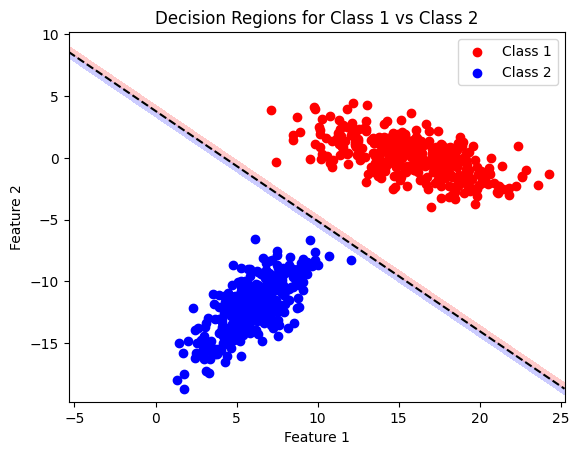

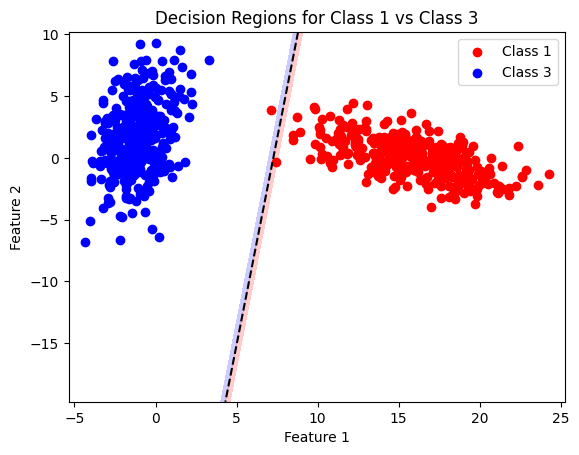

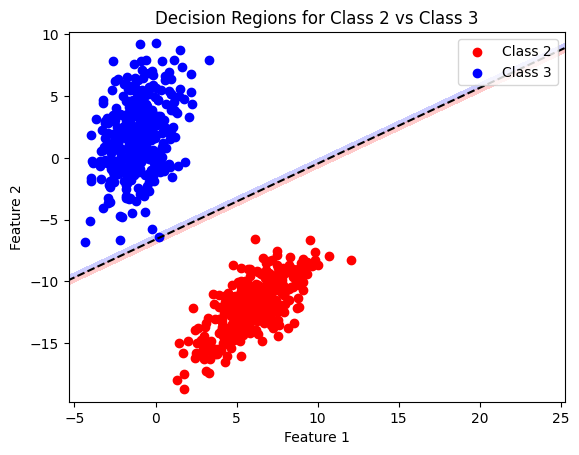

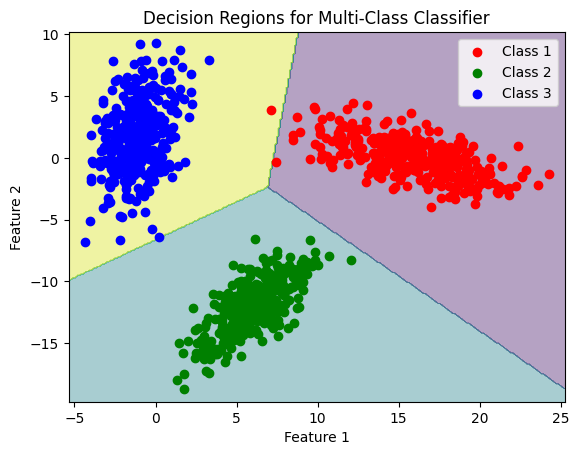

| ClassName        |   Actual_Class1 |   Actual_Class2 |   Actual_Class3 |
|------------------+-----------------+-----------------+-----------------|
| Predicted_class1 |             148 |               0 |               0 |
| Predicted_class2 |               0 |             149 |               0 |
| Predicted_class3 |               1 |               0 |             149 |
Class Accuracies:
 [0.99328859 1.         1.        ]
Class Precisions:
 [1.         1.         0.99333333]
Class Recalls:
 [0.99328859 1.         1.        ]
Class F-Measures:
 [0.996633   1.         0.99665552]
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Precision | 0.997778 |
+-----------+----------+
| Recall    | 0.997763 |
+-----------+----------+
| F1 Score  | 0.997763 |
+-----------+----------+


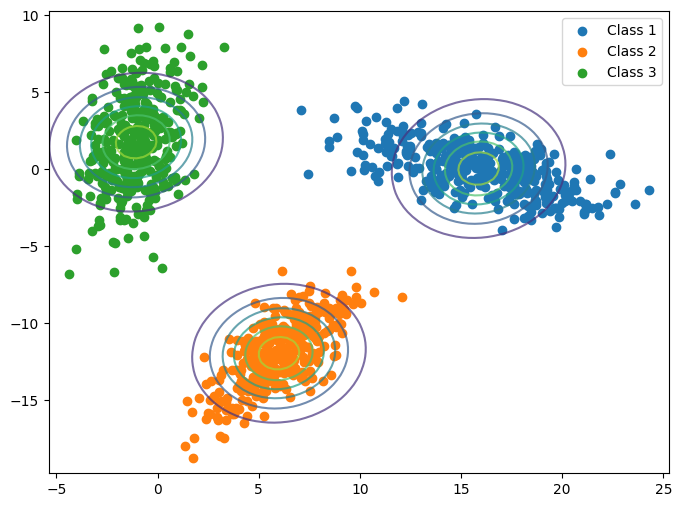

In [48]:
train_file_paths = ['Group13\\LS_Group13\\train\\class1.csv', 'Group13\\LS_Group13\\train\\class2.csv', 'Group13\\LS_Group13\\train\\class3.csv']  # Replace with your actual file paths
test_file_paths = ['Group13\\LS_Group13\\test\\class1.csv', 'Group13\\LS_Group13\\test\\class2.csv', 'Group13\\LS_Group13\\test\\class3.csv']  # Replace with your actual file paths
file_paths=train_file_paths
covariance_option = 2  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

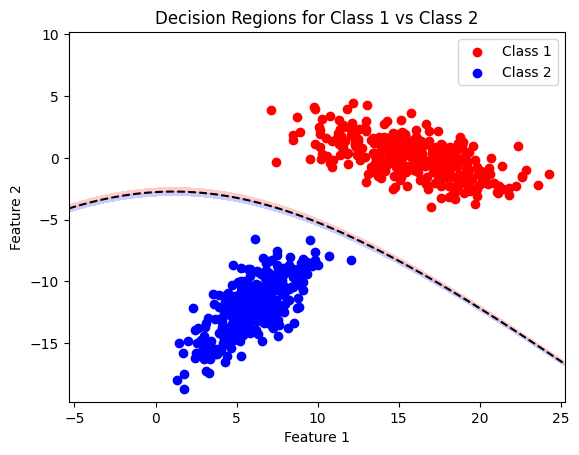

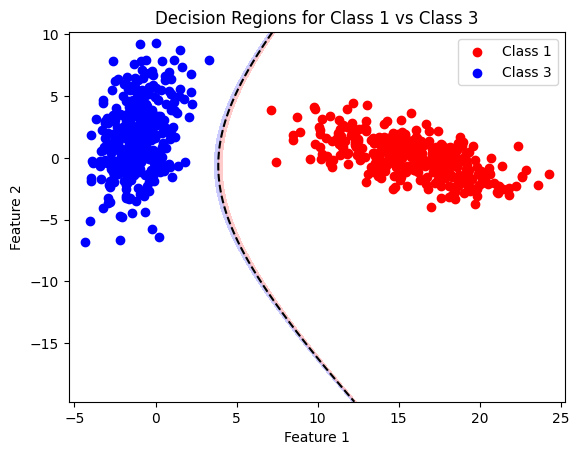

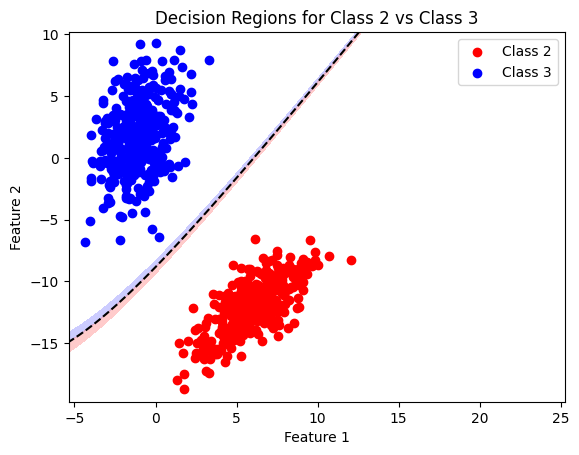

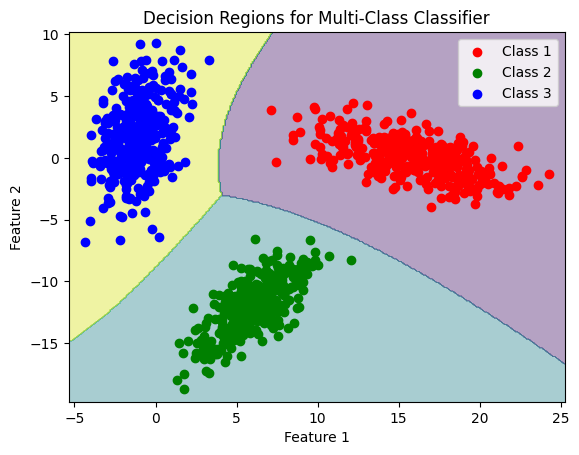

| ClassName        |   Actual_Class1 |   Actual_Class2 |   Actual_Class3 |
|------------------+-----------------+-----------------+-----------------|
| Predicted_class1 |             149 |               0 |               0 |
| Predicted_class2 |               0 |             149 |               0 |
| Predicted_class3 |               0 |               0 |             149 |
Class Accuracies:
 [1. 1. 1.]
Class Precisions:
 [1. 1. 1.]
Class Recalls:
 [1. 1. 1.]
Class F-Measures:
 [1. 1. 1.]
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Precision |       1 |
+-----------+---------+
| Recall    |       1 |
+-----------+---------+
| F1 Score  |       1 |
+-----------+---------+


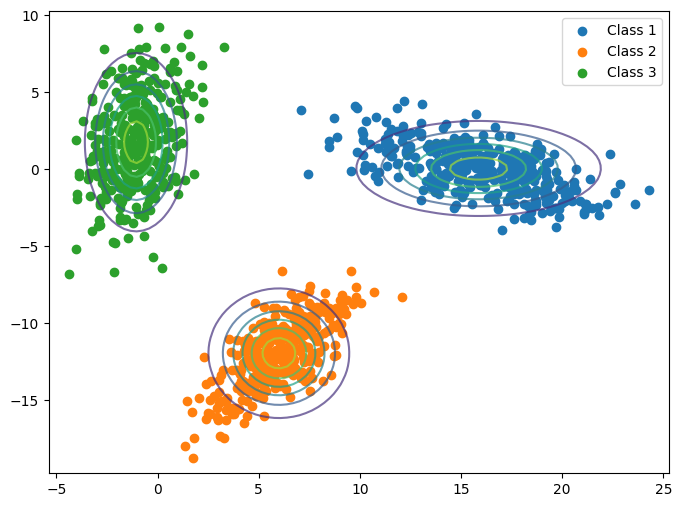

In [49]:
train_file_paths = ['Group13\\LS_Group13\\train\\class1.csv', 'Group13\\LS_Group13\\train\\class2.csv', 'Group13\\LS_Group13\\train\\class3.csv']  # Replace with your actual file paths
test_file_paths = ['Group13\\LS_Group13\\test\\class1.csv', 'Group13\\LS_Group13\\test\\class2.csv', 'Group13\\LS_Group13\\test\\class3.csv']  # Replace with your actual file paths
file_paths=train_file_paths
covariance_option = 3  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

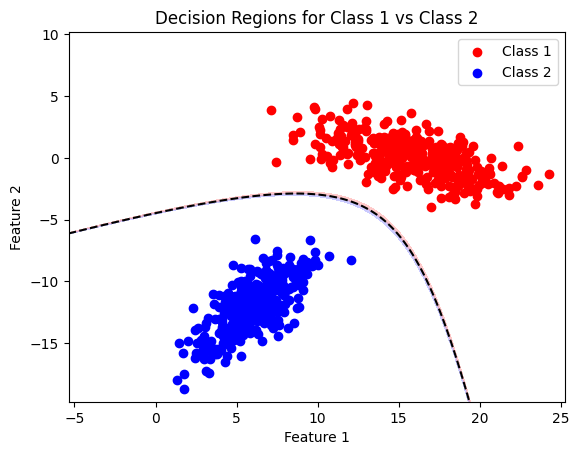

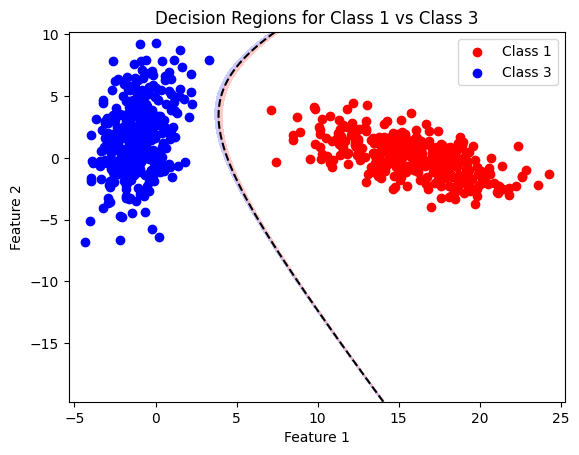

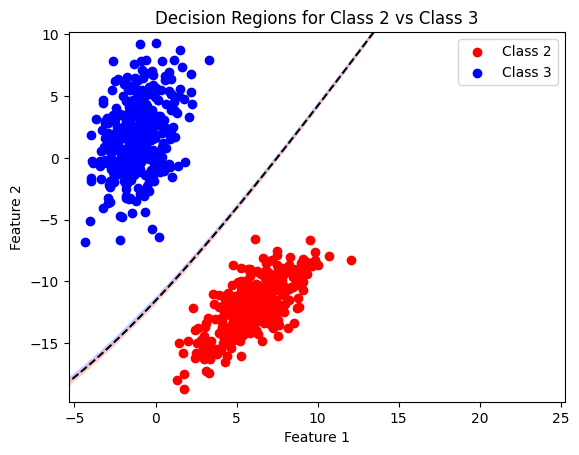

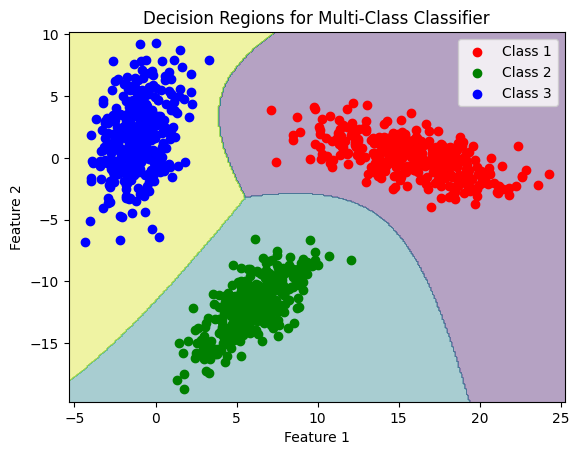

| ClassName        |   Actual_Class1 |   Actual_Class2 |   Actual_Class3 |
|------------------+-----------------+-----------------+-----------------|
| Predicted_class1 |             149 |               0 |               0 |
| Predicted_class2 |               0 |             149 |               0 |
| Predicted_class3 |               0 |               0 |             149 |
Class Accuracies:
 [1. 1. 1.]
Class Precisions:
 [1. 1. 1.]
Class Recalls:
 [1. 1. 1.]
Class F-Measures:
 [1. 1. 1.]
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Precision |       1 |
+-----------+---------+
| Recall    |       1 |
+-----------+---------+
| F1 Score  |       1 |
+-----------+---------+


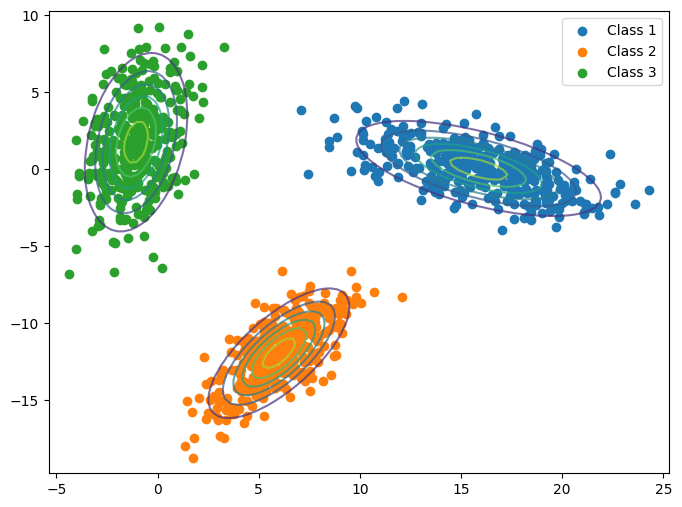

In [50]:
train_file_paths = ['Group13\\LS_Group13\\train\\class1.csv', 'Group13\\LS_Group13\\train\\class2.csv', 'Group13\\LS_Group13\\train\\class3.csv']  # Replace with your actual file paths
test_file_paths = ['Group13\\LS_Group13\\test\\class1.csv', 'Group13\\LS_Group13\\test\\class2.csv', 'Group13\\LS_Group13\\test\\class3.csv']  # Replace with your actual file paths
file_paths=train_file_paths
covariance_option = 4  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

Data Set - NLS_Group13

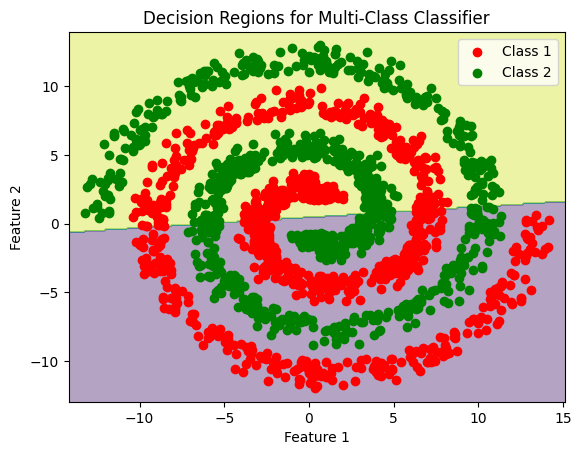

| ClassName        |   Actual_Class1 |   Actual_Class2 |
|------------------+-----------------+-----------------|
| Predicted_class1 |             200 |             190 |
| Predicted_class2 |             190 |             200 |
Class Accuracies:
 [0.51282051 0.51282051]
Class Precisions:
 [0.51282051 0.51282051]
Class Recalls:
 [0.51282051 0.51282051]
Class F-Measures:
 [0.51282051 0.51282051]
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Precision | 0.512821 |
+-----------+----------+
| Recall    | 0.512821 |
+-----------+----------+
| F1 Score  | 0.512821 |
+-----------+----------+


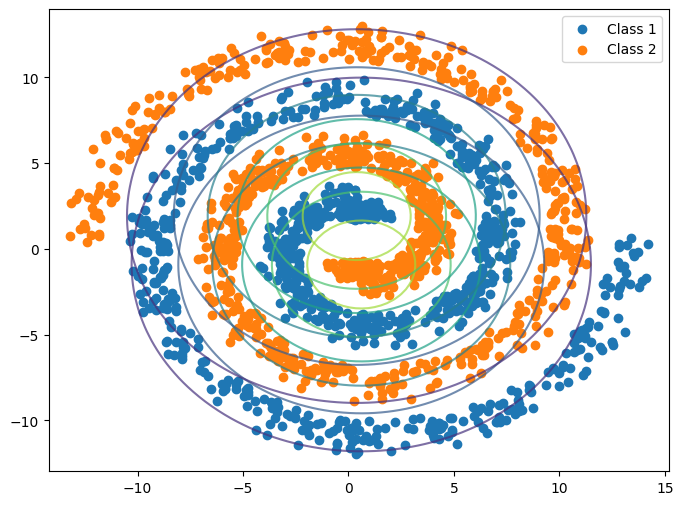

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Step 1: Load the Data
def load_data(file_paths):
    # Load data from all CSV files
    data_classes = [pd.read_csv(file_path).values for file_path in file_paths]
    return data_classes

# Step 2: Compute Covariance Matrices
def compute_covariances(data, option):
    mus = [np.mean(d, axis=0) for d in data]
    
    if option == 1:
        # Option 1: Z = σ² * I (Identity matrix with averaged variance)
        variances = [np.var(d, axis=0) for d in data]
        avg_variance = np.mean([np.mean(var) for var in variances])
        Z = avg_variance * np.eye(len(mus[0]))  # Identity matrix scaled by average variance
        Z_inv = np.linalg.inv(Z)
        Z_invs = [Z_inv] * len(data)  # Same covariance for all classes

    elif option == 2:
        # Option 2: Full Covariance matrix, same for all classes (Σ)
        covariances = [np.cov(d, rowvar=False) for d in data]
        Z = np.mean(covariances, axis=0)  # Average covariance matrix
        Z_inv = np.linalg.inv(Z)
        Z_invs = [Z_inv] * len(data)  # Same covariance for all classes

    elif option == 3:
        # Option 3: Diagonal Covariance matrix, different for each class
        Z_invs = []
        for d in data:
            variances = np.var(d, axis=0)
            Z = np.diag(variances)  # Diagonal matrix with variances
            Z_inv = np.linalg.inv(Z)
            Z_invs.append(Z_inv)

    elif option == 4:
        # Option 4: Full Covariance matrix, different for each class
        Z_invs = []
        for d in data:
            Z = np.cov(d, rowvar=False)  # Full covariance matrix for each class
            Z_inv = np.linalg.inv(Z)
            Z_invs.append(Z_inv)

    else:
        raise ValueError("Invalid option. Please choose a valid option (1, 2, 3, or 4).")
    
    return mus, Z_invs

# Decision function for two classes using the selected covariance matrices
def decision_function(x, mu_i, mu_j, Z_inv_i, Z_inv_j, P_C_i, P_C_j, option):
    if option == 1 or option == 2:
        # Options 1 and 2: Same Z_inv for both classes
        Z_inv = Z_inv_i  # or Z_inv_j, since they are the same
        mu_diff = mu_i - mu_j
        log_prior_ratio = np.log(P_C_i / P_C_j)
        g_x = (Z_inv @ mu_diff).T @ x - 0.5 * (Z_inv @ mu_diff).T @ (mu_i + mu_j) + log_prior_ratio
    elif option == 3 or option == 4:
        # Options 3 and 4: Different Z_inv for each class
        g_x = (-0.5 * (x - mu_i).T @ Z_inv_i @ (x - mu_i) + np.log(P_C_i) 
               + 0.5 * (x - mu_j).T @ Z_inv_j @ (x - mu_j) - np.log(P_C_j))
    else:
        raise ValueError("Invalid option. Please choose a valid option (1, 2, 3, or 4).")
    
    return g_x

# Classify a point using all pairs of classes
def classify_point(x, mus, Z_invs, priors, option):
    num_classes = len(mus)
    scores = np.zeros(num_classes)
    
    # Compare each class against every other class
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                score = decision_function(x, mus[i], mus[j], Z_invs[i], Z_invs[j], priors[i], priors[j], option)
                if score > 0:
                    scores[i] += 1
                else:
                    scores[j] += 1
    
    # Determine the class with the highest score
    return np.argmax(scores)

# Plotting the decision regions
def plot_decision_regions(data_classes, mus, Z_invs, priors, option):
    # Determine the plot boundaries
    all_data = np.vstack(data_classes)
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z_grid = np.array([classify_point(np.array([x, y]), mus, Z_invs, priors, option) for x, y in zip(xx.ravel(), yy.ravel())])
    Z_grid = Z_grid.reshape(xx.shape)

    plt.contourf(xx, yy, Z_grid, alpha=0.4)

    # Plot data points for each class
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']  # Add more colors if needed
    for i, data_class in enumerate(data_classes):
        plt.scatter(data_class[:, 0], data_class[:, 1], color=colors[i % len(colors)], label=f'Class {i+1}')
    
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Regions for Multi-Class Classifier')
    plt.show()

# Plotting decision regions between each pair of classes
def plot_pairwise_decision_regions(data_classes, mus, Z_invs, priors, option):
    num_classes = len(data_classes)
    all_data = np.vstack(data_classes)
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    for i in range(num_classes):
        for j in range(i+1, num_classes):
            Z_grid = np.array([decision_function(np.array([x, y]), mus[i], mus[j], Z_invs[i], Z_invs[j], priors[i], priors[j], option) 
                               for x, y in zip(xx.ravel(), yy.ravel())])
            Z_grid = Z_grid.reshape(xx.shape)

            # Plot decision boundary and regions
            plt.contourf(xx, yy, Z_grid, alpha=0.4, levels=[-1, 0, 1], cmap=plt.cm.bwr)
            plt.contour(xx, yy, Z_grid, levels=[0], colors='k', linestyles='--')
            plt.scatter(data_classes[i][:, 0], data_classes[i][:, 1], color='red', label=f'Class {i+1}')
            plt.scatter(data_classes[j][:, 0], data_classes[j][:, 1], color='blue', label=f'Class {j+1}')
            plt.legend()
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.title(f'Decision Regions for Class {i+1} vs Class {j+1}')
            plt.show()

# Plot constant density contours
def plot_density_contours(train_data_classes, mus, Z_invs):
    # Concatenate all class data into a single array
    all_data = np.vstack(train_data_classes)
    
    # Create a meshgrid for plotting
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1
    X, Y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    pos = np.dstack((X, Y))

    plt.figure(figsize=(8, 6))

    for mu, Z_inv in zip(mus, Z_invs):
        diff = pos - mu
        Z = np.exp(-0.5 * np.einsum('...k,kl,...l->...', diff, Z_inv, diff))
        plt.contour(X, Y, Z, alpha=0.7)

    # Scatter plot the data points for each class
    for i, class_data in enumerate(train_data_classes):
        plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {i+1}')

    plt.legend()
    plt.show()

# Evaluate the classifier and compute metrics
# Evaluate the classifier and compute metrics
def evaluate_classifier(data_classes, mus, Z_invs, priors, option):
    y_true = []
    y_pred = []
    
    for i, data_class in enumerate(data_classes):
        for point in data_class:
            predicted_class = classify_point(point, mus, Z_invs, priors, option)
            y_true.append(i)
            y_pred.append(predicted_class)
    
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix=cm.T
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    class_precisions = precision_score(y_true, y_pred, average=None)
    class_recalls = recall_score(y_true, y_pred, average=None)
    class_f_measures = f1_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    make_table=[]
    heade=['ClassName']
    for itera1 in range (len(conf_matrix)):
        temp=[f'Predicted_class{itera1+1}']
        for itera2 in range (len(conf_matrix[0])):
            temp.append(conf_matrix[itera1][itera2])
        heade.append(f'Actual_Class{itera1+1}')
        make_table.append(temp)
    print(tabulate(make_table,headers=heade,tablefmt='orgtbl'))
    print("Class Accuracies:\n", class_accuracies)
    print("Class Precisions:\n", class_precisions)
    print("Class Recalls:\n", class_recalls)
    print("Class F-Measures:\n", class_f_measures)
    # Print metrics in tabular format
    print(tabulate([['Precision', precision], ['Recall', recall], ['F1 Score', f1]], headers=['Metric', 'Value'], tablefmt='grid'))

# Main function to drive the code
def main(file_paths, train_file_paths, test_file_paths, covariance_option):
    # Step 1: Load the data
    data_classes = load_data(file_paths)
    train_data_classes = load_data(train_file_paths)
    test_data_classes = load_data(test_file_paths)
    
    # Step 2: Calculate statistics
    mus, Z_invs = compute_covariances(train_data_classes, covariance_option)

    # Calculate prior probabilities for each class
    total_samples = sum(len(d) for d in train_data_classes)
    priors = [len(d) / total_samples for d in train_data_classes]
    
    # Step 3: Plot decision regions for each pair of classes
    # plot_pairwise_decision_regions(data_classes, mus, Z_invs, priors, covariance_option)

    # Step 4: Plot decision regions
    plot_decision_regions(train_data_classes, mus, Z_invs, priors, covariance_option)
    
    # Step 5: Evaluate classifier
    evaluate_classifier(test_data_classes, mus, Z_invs, priors, covariance_option)
    
    # Step 6: Plot constant density contours
    plot_density_contours(train_data_classes, mus, Z_invs)


train_file_paths = ['Group13\\NLS_Group13\\train\\class1.csv', 'Group13\\NLS_Group13\\train\\class2.csv']
test_file_paths = ['Group13\\NLS_Group13\\test\\class1.csv', 'Group13\\NLS_Group13\\test\\class2.csv']  # Replace with your actual file paths
file_paths=train_file_paths
covariance_option = 1  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

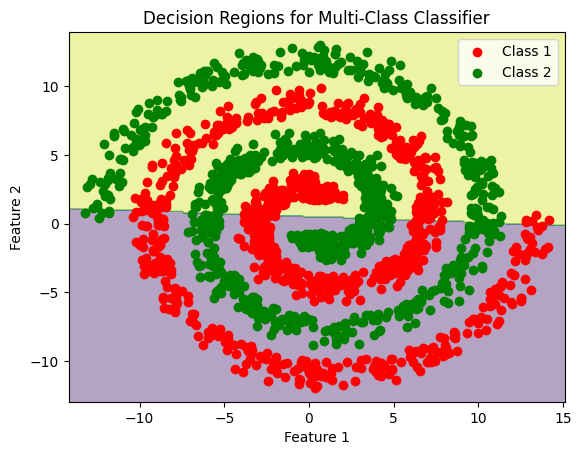

| ClassName        |   Actual_Class1 |   Actual_Class2 |
|------------------+-----------------+-----------------|
| Predicted_class1 |             200 |             190 |
| Predicted_class2 |             190 |             200 |
Class Accuracies:
 [0.51282051 0.51282051]
Class Precisions:
 [0.51282051 0.51282051]
Class Recalls:
 [0.51282051 0.51282051]
Class F-Measures:
 [0.51282051 0.51282051]
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Precision | 0.512821 |
+-----------+----------+
| Recall    | 0.512821 |
+-----------+----------+
| F1 Score  | 0.512821 |
+-----------+----------+


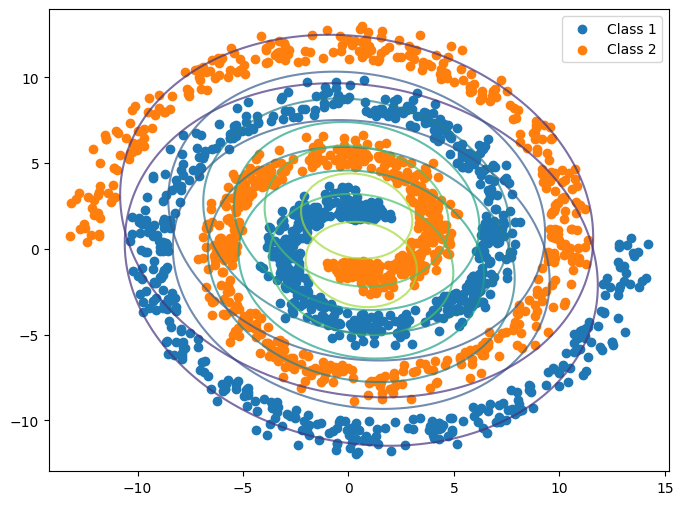

In [52]:
# Example usage
train_file_paths = ['Group13\\NLS_Group13\\train\\class1.csv', 'Group13\\NLS_Group13\\train\\class2.csv']  # Replace with your actual file paths
test_file_paths = ['Group13\\NLS_Group13\\test\\class1.csv', 'Group13\\NLS_Group13\\test\\class2.csv']  # Replace with your actual file paths
file_paths=train_file_paths
covariance_option = 2  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

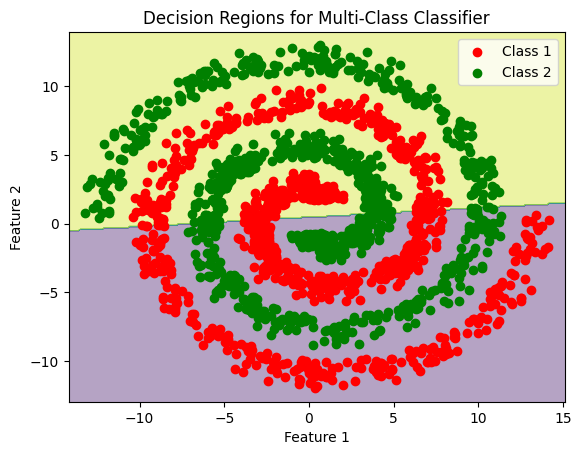

| ClassName        |   Actual_Class1 |   Actual_Class2 |
|------------------+-----------------+-----------------|
| Predicted_class1 |             201 |             189 |
| Predicted_class2 |             189 |             201 |
Class Accuracies:
 [0.51538462 0.51538462]
Class Precisions:
 [0.51538462 0.51538462]
Class Recalls:
 [0.51538462 0.51538462]
Class F-Measures:
 [0.51538462 0.51538462]
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Precision | 0.515385 |
+-----------+----------+
| Recall    | 0.515385 |
+-----------+----------+
| F1 Score  | 0.515385 |
+-----------+----------+


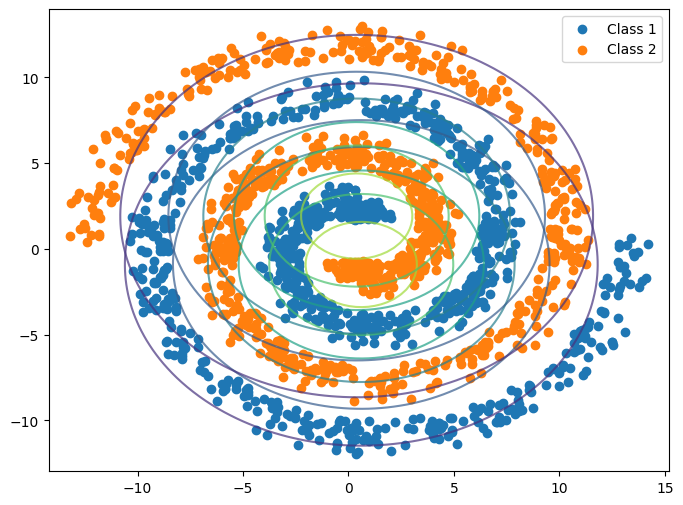

In [53]:
# Example usage
train_file_paths = ['Group13\\NLS_Group13\\train\\class1.csv', 'Group13\\NLS_Group13\\train\\class2.csv']  # Replace with your actual file paths
test_file_paths = ['Group13\\NLS_Group13\\test\\class1.csv', 'Group13\\NLS_Group13\\test\\class2.csv']  # Replace with your actual file paths
file_paths=train_file_paths
covariance_option = 3  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

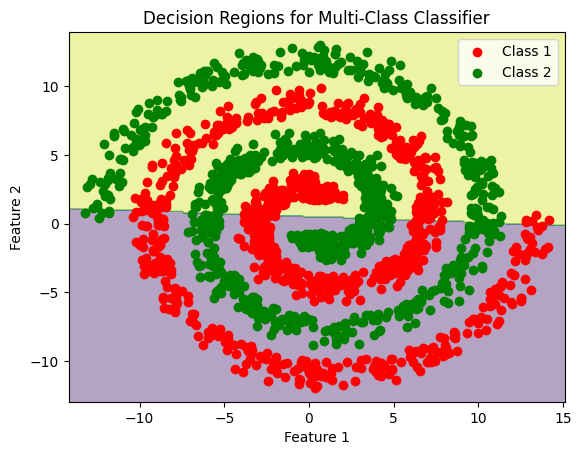

| ClassName        |   Actual_Class1 |   Actual_Class2 |
|------------------+-----------------+-----------------|
| Predicted_class1 |             200 |             190 |
| Predicted_class2 |             190 |             200 |
Class Accuracies:
 [0.51282051 0.51282051]
Class Precisions:
 [0.51282051 0.51282051]
Class Recalls:
 [0.51282051 0.51282051]
Class F-Measures:
 [0.51282051 0.51282051]
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Precision | 0.512821 |
+-----------+----------+
| Recall    | 0.512821 |
+-----------+----------+
| F1 Score  | 0.512821 |
+-----------+----------+


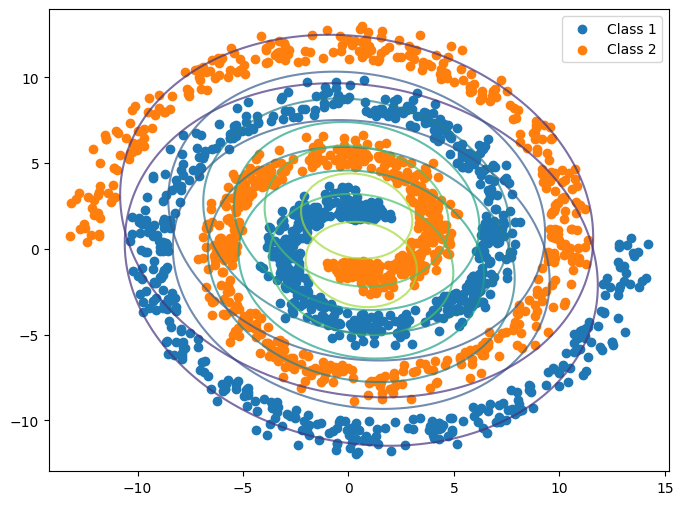

In [54]:
# Example usage
train_file_paths = ['Group13\\NLS_Group13\\train\\class1.csv', 'Group13\\NLS_Group13\\train\\class2.csv']  # Replace with your actual file paths
test_file_paths = ['Group13\\NLS_Group13\\test\\class1.csv', 'Group13\\NLS_Group13\\test\\class2.csv']  # Replace with your actual file paths
file_paths=train_file_paths
covariance_option = 4  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Step 1: Load the Data
def load_data(file_paths):
    # Load data from all CSV files
    data_classes = [pd.read_csv(file_path).values for file_path in file_paths]
    return data_classes

# Step 2: Compute Covariance Matrices
def compute_covariances(data, option):
    mus = [np.mean(d, axis=0) for d in data]
    
    if option == 1:
        # Option 1: Z = σ² * I (Identity matrix with averaged variance)
        variances = [np.var(d, axis=0) for d in data]
        avg_variance = np.mean([np.mean(var) for var in variances])
        Z = avg_variance * np.eye(len(mus[0]))  # Identity matrix scaled by average variance
        Z_inv = np.linalg.inv(Z)
        Z_invs = [Z_inv] * len(data)  # Same covariance for all classes

    elif option == 2:
        # Option 2: Full Covariance matrix, same for all classes (Σ)
        covariances = [np.cov(d, rowvar=False) for d in data]
        Z = np.mean(covariances, axis=0)  # Average covariance matrix
        Z_inv = np.linalg.inv(Z)
        Z_invs = [Z_inv] * len(data)  # Same covariance for all classes

    elif option == 3:
        # Option 3: Diagonal Covariance matrix, different for each class
        Z_invs = []
        for d in data:
            variances = np.var(d, axis=0)
            Z = np.diag(variances)  # Diagonal matrix with variances
            Z_inv = np.linalg.inv(Z)
            Z_invs.append(Z_inv)

    elif option == 4:
        # Option 4: Full Covariance matrix, different for each class
        Z_invs = []
        for d in data:
            Z = np.cov(d, rowvar=False)  # Full covariance matrix for each class
            Z_inv = np.linalg.inv(Z)
            Z_invs.append(Z_inv)

    else:
        raise ValueError("Invalid option. Please choose a valid option (1, 2, 3, or 4).")
    
    return mus, Z_invs

# Decision function for two classes using the selected covariance matrices
def decision_function(x, mu_i, mu_j, Z_inv_i, Z_inv_j, P_C_i, P_C_j, option):
    if option == 1 or option == 2:
        # Options 1 and 2: Same Z_inv for both classes
        Z_inv = Z_inv_i  # or Z_inv_j, since they are the same
        mu_diff = mu_i - mu_j
        log_prior_ratio = np.log(P_C_i / P_C_j)
        g_x = (Z_inv @ mu_diff).T @ x - 0.5 * (Z_inv @ mu_diff).T @ (mu_i + mu_j) + log_prior_ratio
    elif option == 3 or option == 4:
        # Options 3 and 4: Different Z_inv for each class
        g_x = (-0.5 * (x - mu_i).T @ Z_inv_i @ (x - mu_i) + np.log(P_C_i) 
               + 0.5 * (x - mu_j).T @ Z_inv_j @ (x - mu_j) - np.log(P_C_j))
    else:
        raise ValueError("Invalid option. Please choose a valid option (1, 2, 3, or 4).")
    
    return g_x

# Classify a point using all pairs of classes
def classify_point(x, mus, Z_invs, priors, option):
    num_classes = len(mus)
    scores = np.zeros(num_classes)
    
    # Compare each class against every other class
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                score = decision_function(x, mus[i], mus[j], Z_invs[i], Z_invs[j], priors[i], priors[j], option)
                if score > 0:
                    scores[i] += 1
                else:
                    scores[j] += 1
    
    # Determine the class with the highest score
    return np.argmax(scores)

# Plotting the decision regions
def plot_decision_regions(data_classes, mus, Z_invs, priors, option):
    # Determine the plot boundaries
    all_data = np.vstack(data_classes)
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 5), np.arange(y_min, y_max, 5))
    Z_grid = np.array([classify_point(np.array([x, y]), mus, Z_invs, priors, option) for x, y in zip(xx.ravel(), yy.ravel())])
    Z_grid = Z_grid.reshape(xx.shape)

    plt.contourf(xx, yy, Z_grid, alpha=0.4)

    # Plot data points for each class
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']  # Add more colors if needed
    for i, data_class in enumerate(data_classes):
        plt.scatter(data_class[:, 0], data_class[:, 1], color=colors[i % len(colors)], label=f'Class {i+1}')
    
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Regions for Multi-Class Classifier')
    plt.show()

# Plotting decision regions between each pair of classes
def plot_pairwise_decision_regions(data_classes, mus, Z_invs, priors, option):
    num_classes = len(data_classes)
    all_data = np.vstack(data_classes)
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max,5), np.arange(y_min, y_max,5))

    for i in range(num_classes):
        for j in range(i+1, num_classes):
            Z_grid = np.array([decision_function(np.array([x, y]), mus[i], mus[j], Z_invs[i], Z_invs[j], priors[i], priors[j], option) 
                               for x, y in zip(xx.ravel(), yy.ravel())])
            Z_grid = Z_grid.reshape(xx.shape)

            # Plot decision boundary and regions
            plt.contourf(xx, yy, Z_grid, alpha=0.4, levels=[-1, 0, 1], cmap=plt.cm.bwr)
            plt.contour(xx, yy, Z_grid, levels=[0], colors='k', linestyles='--')
            plt.scatter(data_classes[i][:, 0], data_classes[i][:, 1], color='red', label=f'Class {i+1}')
            plt.scatter(data_classes[j][:, 0], data_classes[j][:, 1], color='blue', label=f'Class {j+1}')
            plt.legend()
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.title(f'Decision Regions for Class {i+1} vs Class {j+1}')
            plt.show()

# Plot constant density contours
def plot_density_contours(train_data_classes, mus, Z_invs):
    # Concatenate all class data into a single array
    all_data = np.vstack(train_data_classes)
    
    # Create a meshgrid for plotting
    x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
    y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1
    X, Y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    pos = np.dstack((X, Y))

    plt.figure(figsize=(8, 6))

    for mu, Z_inv in zip(mus, Z_invs):
        diff = pos - mu
        Z = np.exp(-0.5 * np.einsum('...k,kl,...l->...', diff, Z_inv, diff))
        plt.contour(X, Y, Z, alpha=0.7)

    # Scatter plot the data points for each class
    for i, class_data in enumerate(train_data_classes):
        plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {i+1}')

    plt.legend()
    plt.show()

# Evaluate the classifier and compute metrics
# Evaluate the classifier and compute metrics
def evaluate_classifier(data_classes, mus, Z_invs, priors, option):
    y_true = []
    y_pred = []
    
    for i, data_class in enumerate(data_classes):
        for point in data_class:
            predicted_class = classify_point(point, mus, Z_invs, priors, option)
            y_true.append(i)
            y_pred.append(predicted_class)
    
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix=cm.T
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    class_precisions = precision_score(y_true, y_pred, average=None)
    class_recalls = recall_score(y_true, y_pred, average=None)
    class_f_measures = f1_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    make_table=[]
    heade=['ClassName']
    for itera1 in range (len(conf_matrix)):
        temp=[f'Predicted_class{itera1+1}']
        for itera2 in range (len(conf_matrix[0])):
            temp.append(conf_matrix[itera1][itera2])
        heade.append(f'Actual_Class{itera1+1}')
        make_table.append(temp)
    print(tabulate(make_table,headers=heade,tablefmt='orgtbl'))
    print("Class Accuracies:\n", class_accuracies)
    print("Class Precisions:\n", class_precisions)
    print("Class Recalls:\n", class_recalls)
    print("Class F-Measures:\n", class_f_measures)
    # Print metrics in tabular format
    print(tabulate([['Precision', precision], ['Recall', recall], ['F1 Score', f1]], headers=['Metric', 'Value'], tablefmt='grid'))

# Main function to drive the code
def main(file_paths, train_file_paths, test_file_paths, covariance_option):
    # Step 1: Load the data
    data_classes = load_data(file_paths)
    train_data_classes = load_data(train_file_paths)
    test_data_classes = load_data(test_file_paths)
    
    # Step 2: Calculate statistics
    mus, Z_invs = compute_covariances(train_data_classes, covariance_option)

    # Calculate prior probabilities for each class
    total_samples = sum(len(d) for d in train_data_classes)
    priors = [len(d) / total_samples for d in train_data_classes]
    
    # Step 3: Plot decision regions for each pair of classes
    plot_pairwise_decision_regions(data_classes, mus, Z_invs, priors, covariance_option)

    # Step 4: Plot decision regions
    plot_decision_regions(train_data_classes, mus, Z_invs, priors, covariance_option)
    
    # Step 5: Evaluate classifier
    evaluate_classifier(test_data_classes, mus, Z_invs, priors, covariance_option)
    
    # Step 6: Plot constant density contours
    plot_density_contours(train_data_classes, mus, Z_invs)




# Example usage

train_file_paths = ['Group13\\rd_group13\\train\\class1.csv', 'Group13\\rd_group13\\train\\class2.csv', 'Group13\\rd_group13\\train\\class3.csv']  # Replace with your actual file paths
test_file_paths = ['Group13\\rd_group13\\test\\class1.csv', 'Group13\\rd_group13\\test\\class2.csv', 'Group13\\rd_group13\\test\\class3.csv']  # Replace with your actual file paths
file_paths=train_file_paths
covariance_option = 1  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

FileNotFoundError: [Errno 2] No such file or directory: 'Group13\\rd_group13\\train\\class1.csv'

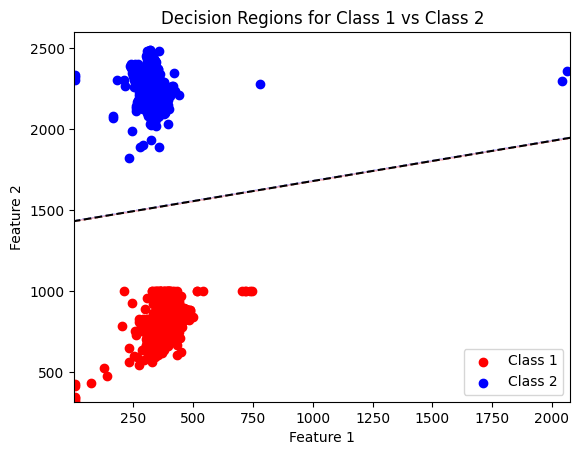

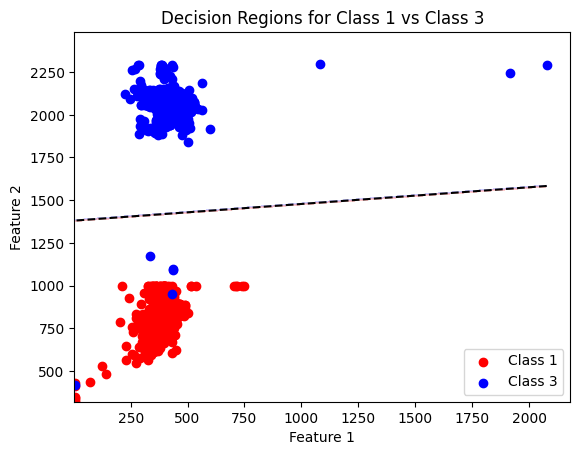

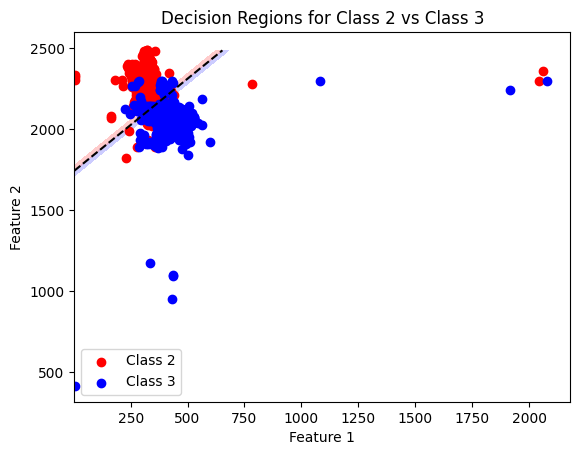

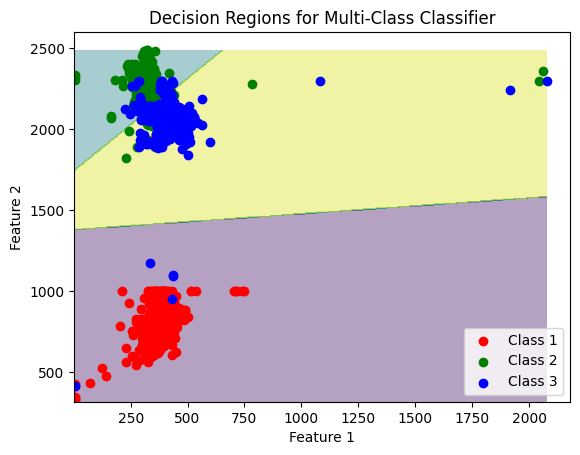

| ClassName        |   Actual_Class1 |   Actual_Class2 |   Actual_Class3 |
|------------------+-----------------+-----------------+-----------------|
| Predicted_class1 |             746 |               3 |              18 |
| Predicted_class2 |               0 |             690 |             346 |
| Predicted_class3 |               0 |              23 |             322 |
Class Accuracies:
 [1.         0.96368715 0.46938776]
Class Precisions:
 [0.9726206  0.66602317 0.93333333]
Class Recalls:
 [1.         0.96368715 0.46938776]
Class F-Measures:
 [0.98612029 0.78767123 0.62463628]
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Precision | 0.857874 |
+-----------+----------+
| Recall    | 0.818436 |
+-----------+----------+
| F1 Score  | 0.804525 |
+-----------+----------+


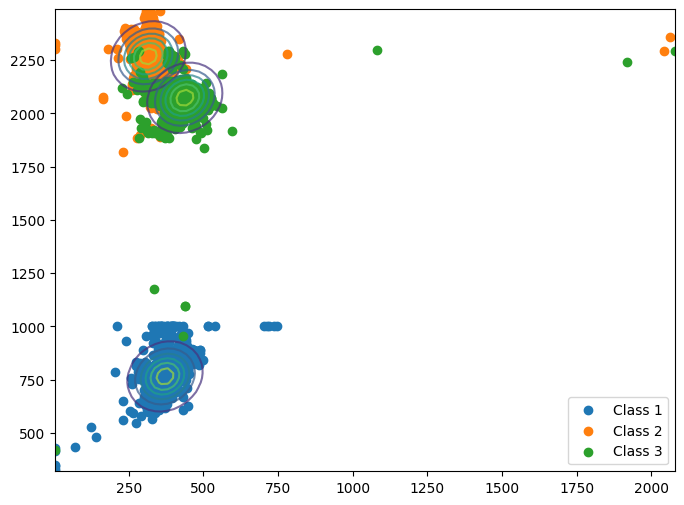

In [56]:
covariance_option = 2  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

In [2]:
covariance_option = 3  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)

FileNotFoundError: [Errno 2] No such file or directory: 'Group13\\rd_group13\\train\\class1.csv'

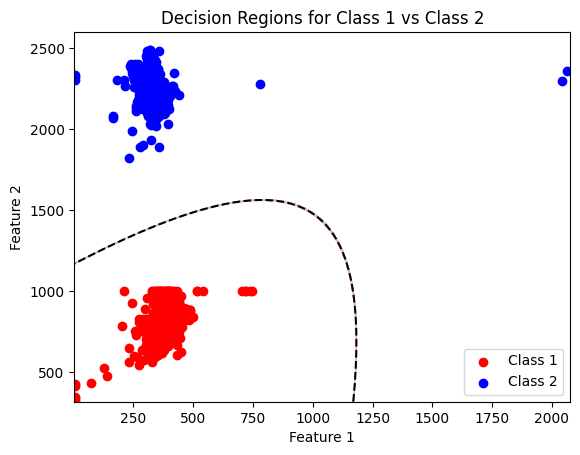

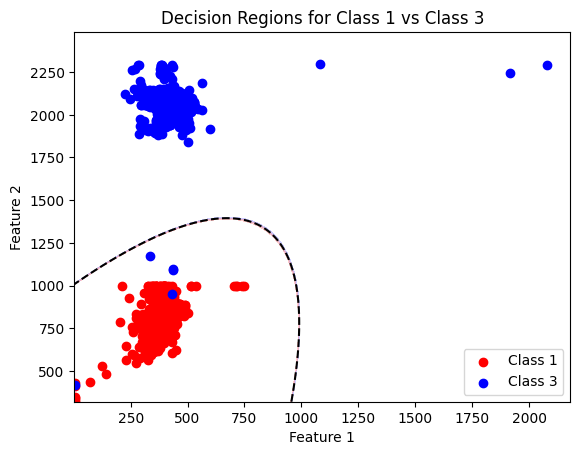

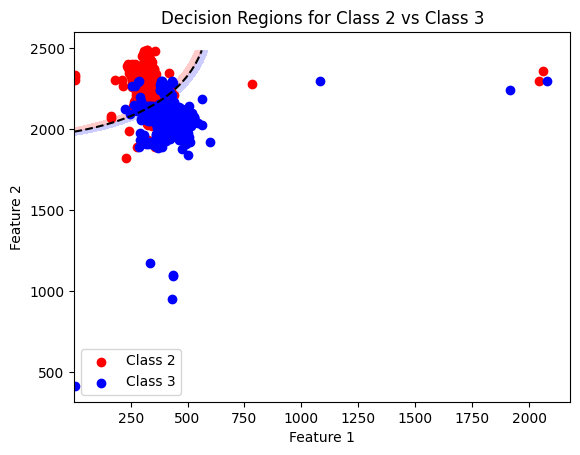

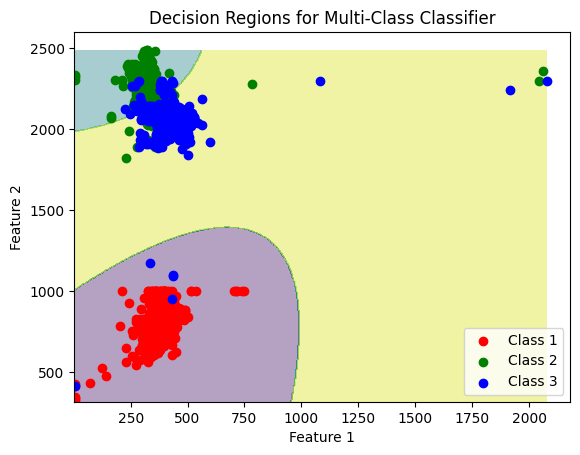

| ClassName        |   Actual_Class1 |   Actual_Class2 |   Actual_Class3 |
|------------------+-----------------+-----------------+-----------------|
| Predicted_class1 |             745 |               3 |              15 |
| Predicted_class2 |               0 |             689 |             346 |
| Predicted_class3 |               1 |              24 |             325 |
Class Accuracies:
 [0.99865952 0.9622905  0.47376093]
Class Precisions:
 [0.97640891 0.66570048 0.92857143]
Class Recalls:
 [0.99865952 0.9622905  0.47376093]
Class F-Measures:
 [0.98740888 0.78697887 0.62741313]
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Precision | 0.857562 |
+-----------+----------+
| Recall    | 0.818901 |
+-----------+----------+
| F1 Score  | 0.805628 |
+-----------+----------+


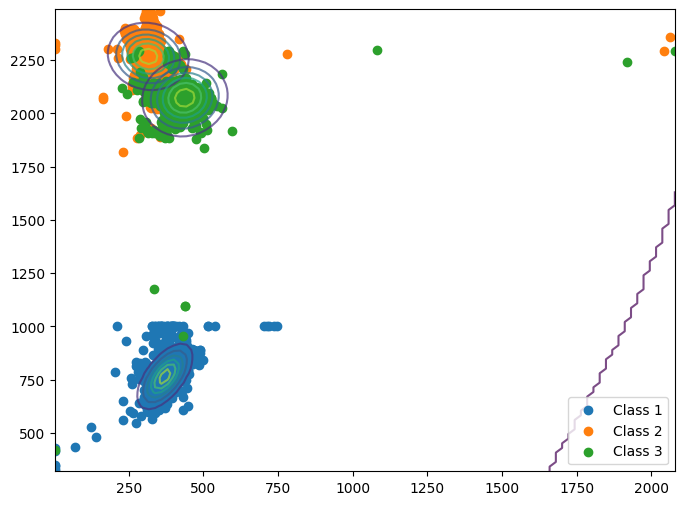

In [58]:
covariance_option = 4  # Choose from options 1, 2, 3, or 4
main(file_paths,train_file_paths, test_file_paths, covariance_option)